In [2]:
import os
import scipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import mne
import pandas as pd
import pandasql as ps

from scipy import signal
from scipy.io import wavfile

from nilearn import plotting

/var/folders/_7/61vbt98120v7tjjx9b62g2ph0000gn/T/ipykernel_60556/3385027754.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# load and preprocess audio

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def preprocess_audio(x, fs, to_fs, lowcut=200, highcut=5000):
    assert x.ndim == 1
    # x = x[:fs * round(len(x) / fs)]  # trim to nearest second

    # Step 1. Bandpass the high quality audio
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=5)

    # Step 2. Downsample to same freq as clinical system
    # Number of new samples is N = n * (to_fs / fs)
    y = signal.resample(y, num=round(x.size / fs * to_fs))

    # Step 3. Take audio envelope
    envelope = np.abs(signal.hilbert(y - y.mean()))
    return envelope

In [5]:
wav_fs, wav_data = wavfile.read('podcast.wav')
wav_fs, wav_data.shape

/var/folders/_7/61vbt98120v7tjjx9b62g2ph0000gn/T/ipykernel_60556/584940798.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wav_fs, wav_data = wavfile.read('podcast.wav')


(44100, (79380000, 2))

In [6]:
audio_envelope = preprocess_audio(wav_data[:, 0], wav_fs, 400)
audio_envelope.shape

(720000,)

# load ECoG data and resample

In [7]:
raw = mne.io.read_raw_fif('raw-ecog-data_ieeg.fif')
raw.load_data()
raw.notch_filter([60,120,180])
raw.filter(l_freq=64, h_freq=199, method='iir')
raw.apply_hilbert(envelope=True)
raw.resample(400)
raw

Opening raw data file raw-ecog-data_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 921600 =      0.000 ...  1800.000 secs
Ready.
Reading 0 ... 921600  =      0.000 ...  1800.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.7s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 64 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 64.00, 199.00 Hz: -6.02, -6.02 dB



Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,160 points
Good channels,160 ECoG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,400.00 Hz
Highpass,64.00 Hz
Lowpass,199.00 Hz


# correlate ECoG with audio envelope

In [8]:
ecog_data = raw.get_data()
ecog_data.shape

(160, 720001)

In [9]:
audio_ecog_corrs = []
for i in range(ecog_data.shape[0]):
    elec_i = ecog_data[i]
    corr = scipy.stats.pearsonr(audio_envelope, elec_i[:-1])
    audio_ecog_corrs.append(corr.statistic)
    print(i, corr)

0 PearsonRResult(statistic=0.04430658166260805, pvalue=1.279501780025174e-309)
1 PearsonRResult(statistic=0.00814809560610723, pvalue=4.712046015862672e-12)
2 PearsonRResult(statistic=0.01096099506108387, pvalue=1.391623711132216e-20)
3 PearsonRResult(statistic=0.049751043139312834, pvalue=0.0)
4 PearsonRResult(statistic=0.00012739975816503937, pvalue=0.9139147084947761)
5 PearsonRResult(statistic=-0.004727865007893494, pvalue=6.0272364025566765e-05)
6 PearsonRResult(statistic=0.04737214527757346, pvalue=0.0)
7 PearsonRResult(statistic=0.0364064797601423, pvalue=1.118901140739986e-209)
8 PearsonRResult(statistic=0.031643718359274854, pvalue=6.937952866285478e-159)
9 PearsonRResult(statistic=0.05780658950415018, pvalue=0.0)
10 PearsonRResult(statistic=0.02760587343578561, pvalue=2.1754975643358735e-121)
11 PearsonRResult(statistic=0.0048043119825816735, pvalue=4.56969749067064e-05)
12 PearsonRResult(statistic=0.07490735745786267, pvalue=0.0)
13 PearsonRResult(statistic=0.009825416347596

# plot correlations on brain

In [10]:
ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info.ch_names])
coords.shape

(160, 3)

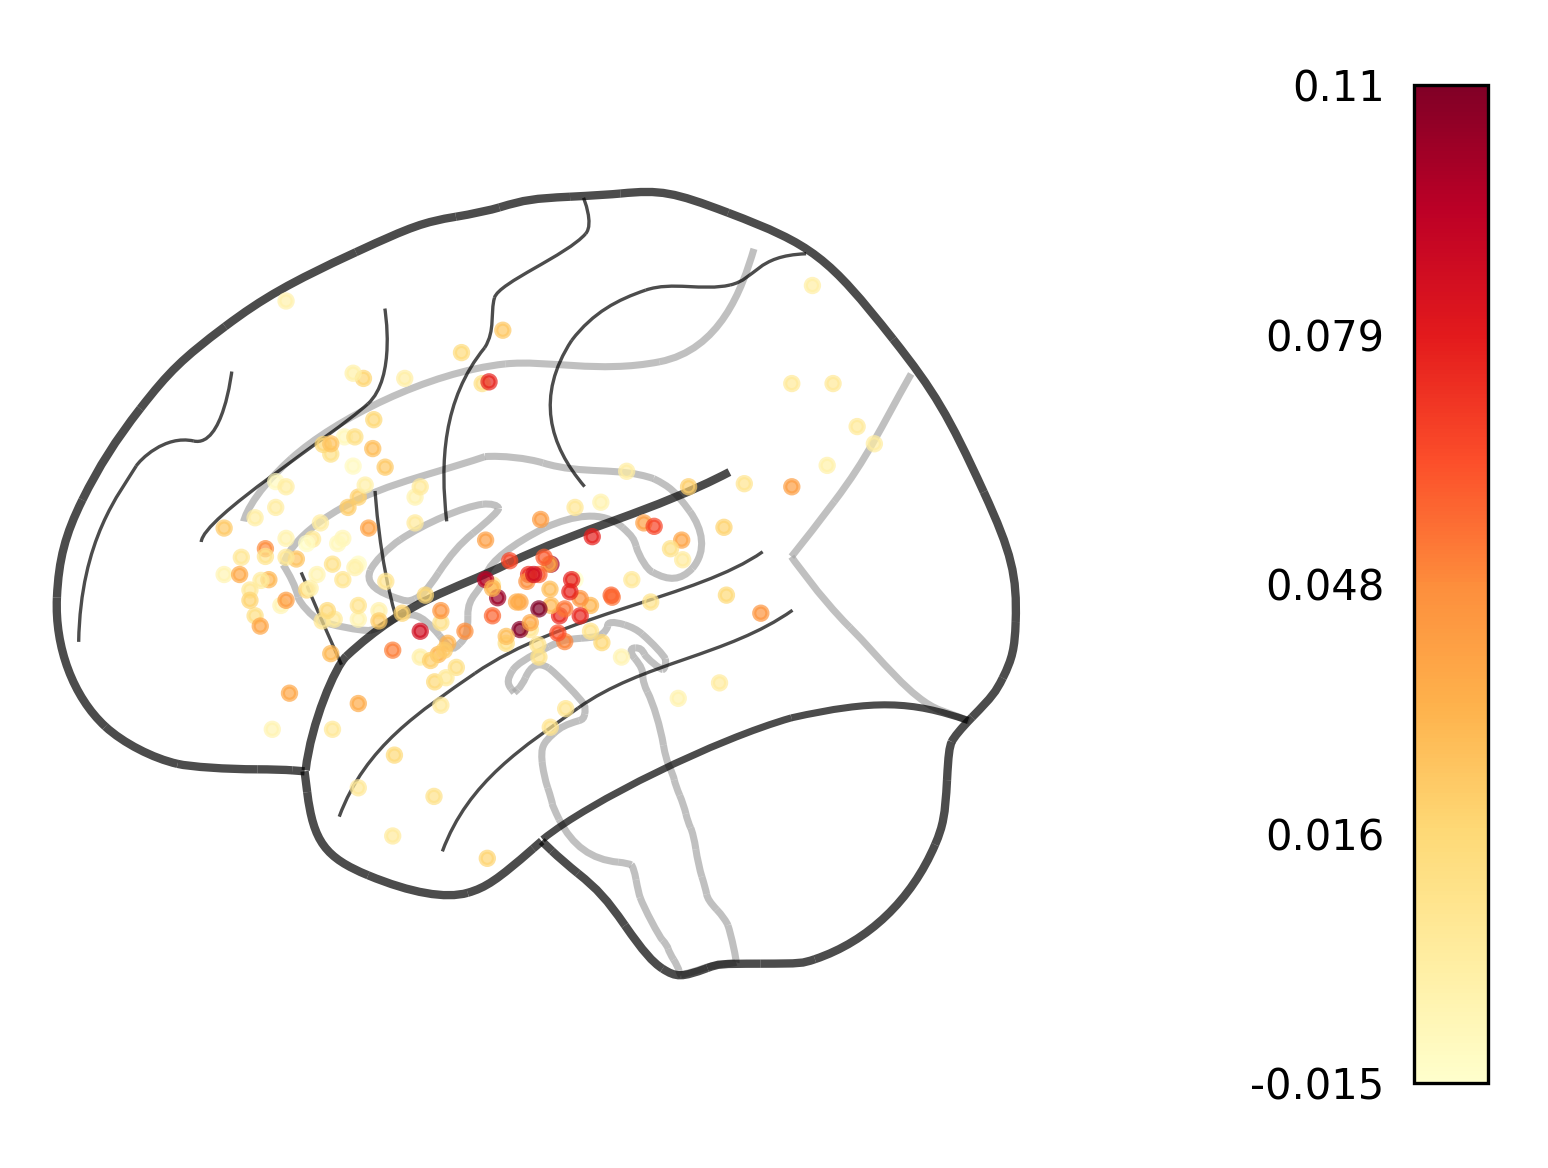

In [11]:
fig, ax = plt.subplots(dpi=300)
plotting.plot_markers(
    node_values=audio_ecog_corrs, 
    node_coords = coords,
    node_cmap=cm.YlOrRd,
    node_size=10,
    # title = 'ACW (Raw and Notch Filter)',
    colorbar=True,
    display_mode='l',
    # output_file = 'avg_acw_location_visual.svg'
    axes=ax
)
plt.savefig('electrode-correlations.svg')

In [12]:
audio_df = pd.DataFrame(audio_ecog_corrs)
audio_df.to_csv('audio-electrode-correlations.csv')